# 2D SGLD iterates in singular potentials

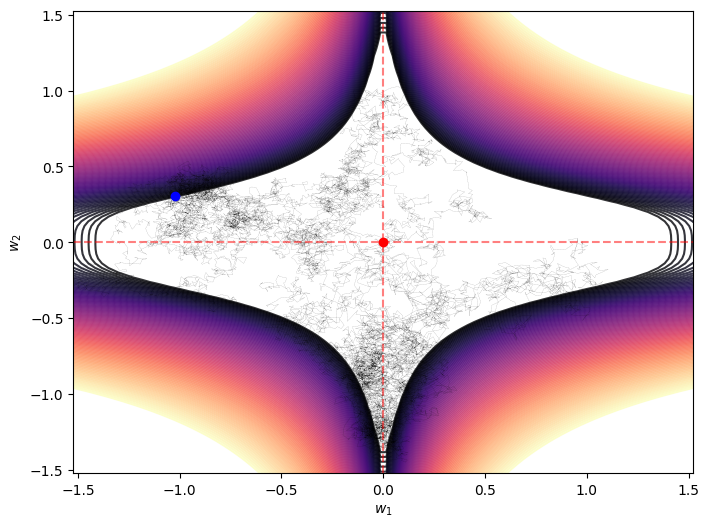

<Axes: >

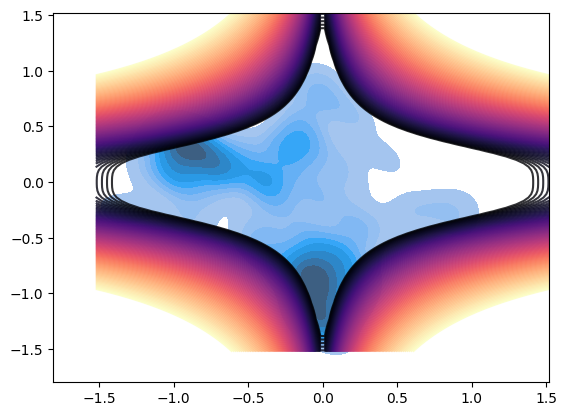

In [321]:
import jax
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, random
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

prior_sigma = 1.0
itemp = 50 * 1.0
@jit
def potential(w):
    w1, w2 = w
    prior_term = (w1**2 + w2**2)
    potential_term = w1**2 * w2**4
    # potential_term = (w1**3 - w2**5)**2
    # potential_term = (w2**2 - w1**2 * (w1 - 1))**2
    # potential_term = (w1 - 1)**2 * (w1**2 + w2**2)**1
    # potential_term = w1 ** 2 + 2 * w2 **2
    # potential_term = (w1**4 - w1**2 * w2 + w2**3)**2
    # potential_term = (w1 * w2**4 - 0.1)**2
    return potential_term * itemp + prior_term / (2*prior_sigma**2)

# Get the gradient of K using JAX's automatic differentiation

gradient = jit(grad(potential))

# Langevin dynamics update step
@jit
def langevin_step(w, epsilon, key):
    key, subkey = random.split(key)
    noise = random.normal(subkey, w.shape) * jnp.sqrt(epsilon)
    update = - 0.5 * epsilon * gradient(w) + noise
    return w + update, key

# Simulate Langevin dynamics
def simulate_langevin(w_init, num_steps, epsilon, key):
    w = jnp.array(w_init)
    trajectory = [w]
    grad_norm = [jnp.sum(gradient(w)**2)]

    for t in range(num_steps):
        factor = 10 / (t + 1)**0.3
        w, key = langevin_step(w, epsilon * factor, key)
        trajectory.append(w)
        grad_norm.append(jnp.sum(gradient(w)**2))
    return jnp.array(trajectory), jnp.array(grad_norm)

# Simulation parameters
# w_init = np.random.rand(2)
w_init = np.array([0., 0.])
# w_init = np.array([0.8, 0.0])
num_steps = 15000
epsilon = 0.0005
key = random.PRNGKey(3)

# Simulate the system
trajectory, grad_norms = simulate_langevin(w_init, num_steps, epsilon, key)

# Plotting the contour and trajectory
val = np.max(np.abs(trajectory))
val = np.max([1.1, val])
w1 = jnp.linspace(-val, val, 100)
w2 = jnp.linspace(-val, val, 100)
W1, W2 = jnp.meshgrid(w1, w2)
Z = potential(jnp.array([W1, W2]))

plt.figure(figsize=(8, 6))
plt.contour(W1, W2, Z, levels=jnp.logspace(0, 2, num=100), norm=LogNorm(), cmap="magma", alpha=0.8)
plt.plot(trajectory[:, 0], trajectory[:, 1], 'k--', linewidth=0.1, markersize=0.1, alpha=0.8)
plt.plot(trajectory[0, 0], trajectory[0, 1], 'ro')
plt.plot(trajectory[-1, 0], trajectory[-1, 1], 'bo')
plt.vlines([0], ymin=-val, ymax=val, alpha=0.5, color="r", linestyles="dashed")
plt.hlines([0], xmin=-val, xmax=val, alpha=0.5, color="r", linestyles="dashed")

# plt.title(f'$w_1^2w_2^4$')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.show()

plt.figure()
plt.contour(W1, W2, Z, levels=jnp.logspace(0, 2, num=100), norm=LogNorm(), cmap="magma", alpha=0.8)
sns.kdeplot(x=trajectory[:, 0], y=trajectory[:, 1], fill=True)



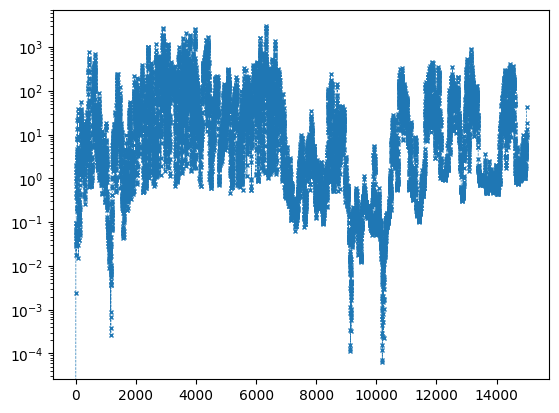

In [322]:
plt.plot(grad_norms, "x--", markersize=3, linewidth=0.5)
plt.yscale('log')

<Axes: >

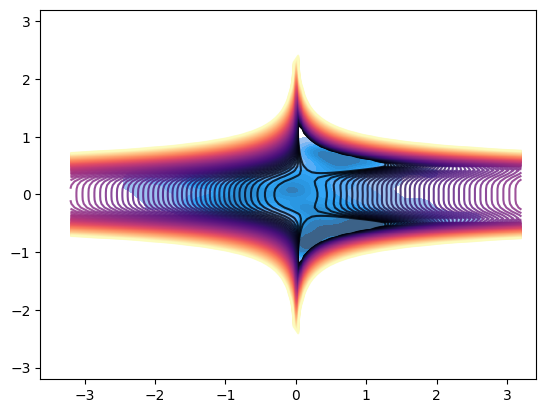

In [116]:
import seaborn as sns
plt.contour(W1, W2, Z, levels=jnp.logspace(0, 2, num=100), norm=LogNorm(), cmap="magma", alpha=0.8)
sns.kdeplot(x=trajectory[:, 0], y=trajectory[:, 1], fill=True)

# SGLD with actual model

Running SGLD
Plotting


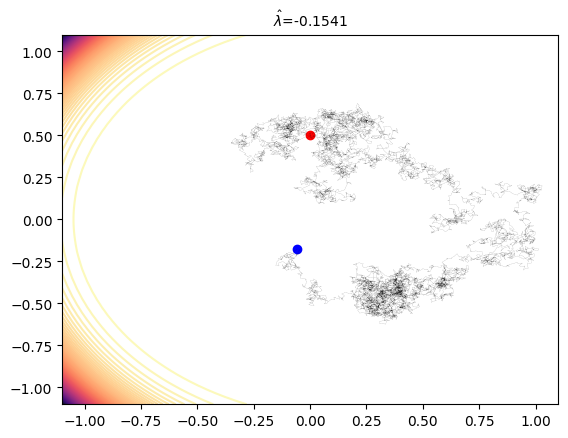

In [364]:
import jax
import jax.numpy as jnp
from jax import random
from jax.scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

# Define the polynomial function
@jax.jit
def p(w):
    w1, w2 = w
    # return (w1 - 1) * (w1**2 + w2**2)**3
    # return (w1**3 - w2**2)**2
    # return w1 * w2**4
    return (w1 - 1) * (w1**2 + w2**2)**3

# Stochastic Gradient Langevin Dynamics
def SGLD_step(key, grad_log_posterior, w, epsilon):
    eta = random.normal(key, shape=w.shape) * jnp.sqrt(epsilon)
    return w + epsilon * grad_log_posterior(w) / 2 + eta

# Function to compute the log-likelihood of the observations given the parameters
@jax.jit
def log_likelihood(w, x, y, sigma):
    mu = p(w) * x
    return jnp.sum(norm.logpdf(y, loc=mu, scale=sigma))

# Function to compute the log-posterior
@jax.jit
def log_posterior(w, x, y, sigma, prior_sigma, itemp=1.0):
    loglikehood_val = log_likelihood(w, x, y, sigma) 
    prior = jnp.sum(norm.logpdf(w, loc=0, scale=prior_sigma))
    return loglikehood_val * itemp + prior

# Function to run SGLD
def run_SGLD(grad_log_posterior_fn, w_init, epsilon, num_steps, key):
    w = w_init
    trajectory = [w]
    for i in range(num_steps):
        key, subkey = random.split(key)
        w = SGLD_step(subkey, grad_log_posterior_fn, w, epsilon)
        trajectory.append(w)
    return jnp.array(trajectory)

# Initialize parameters
w_init = jnp.array([0.0, 0.5]) 
# w_init = np.random.rand(2)
sigma = 0.3
prior_sigma = 10.0
epsilon = 0.0001
num_steps = 10000
key = random.PRNGKey(2)

# Generate some data
N = 1000
true_w = jnp.array([0.0, 0.0])
key, subkey = random.split(key)
x = random.normal(key, shape=(N,))
y = 0 * x + sigma * random.normal(subkey, shape=(N,))

# Run SGLD
print("Running SGLD")
itemp = 1 / jnp.log(N)
# itemp = 10
grad_log_posterior_fn = jax.jit(jax.grad(lambda w: log_posterior(w, x, y, sigma, prior_sigma, itemp=itemp)))
trajectory = run_SGLD(grad_log_posterior_fn, w_init, epsilon, num_steps, key)

# Plotting
print("Plotting")
val = np.max(np.abs(trajectory))
val = np.max([1.1, val])
w1_vals = jnp.linspace(-val, val, 100)
w2_vals = jnp.linspace(-val, val, 100)
# val = 0.1
# w1_vals = jnp.linspace(trajectory[:, 0].min() - val, trajectory[:, 0].max() + val, 100)
# w2_vals = jnp.linspace(trajectory[:, 1].min() - val, trajectory[:, 1].max() + val, 100)

W1, W2 = jnp.meshgrid(w1_vals, w2_vals)
Z = jnp.array([[log_posterior(jnp.array([w1, w2]), x, y, sigma, prior_sigma) 
                for w1 in w1_vals] 
                for w2 in w2_vals]) / N
plt.contour(W1, W2, Z, levels=150, cmap='magma')
# plt.contour(W1, W2, Z, levels=100, norm=SymLogNorm(100000), cmap="magma", alpha=0.8)
plt.plot(trajectory[:, 0], trajectory[:, 1], 'k--', linewidth=0.1, markersize=0.1, alpha=0.8)
plt.scatter(trajectory[0, 0], trajectory[0, 1], c='red')
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], c='blue')
samples = trajectory
# samples = trajectory[trajectory[:, 0] < 0.7]
hatlambda = (-np.mean([log_likelihood(w, x, y, sigma) for w in samples]) + log_likelihood([0, 0], x, y, sigma)) / np.log(N)

symhatlambda = "$\hat{\lambda}$"
plt.title(f"{symhatlambda}={hatlambda:.4f}", fontsize=10)
plt.show()


In [365]:
2 / 12

0.16666666666666666

In [358]:
# samples = trajectory
samples = trajectory[trajectory[:, 0] < 0.7]
hatlambda = (-np.mean([log_likelihood(w, x, y, sigma) for w in samples]) + log_likelihood([0, 0], x, y, sigma)) / np.log(N)
hatlambda

Array(0.09259859, dtype=float32)

---
# SGHMC
---

Plotting


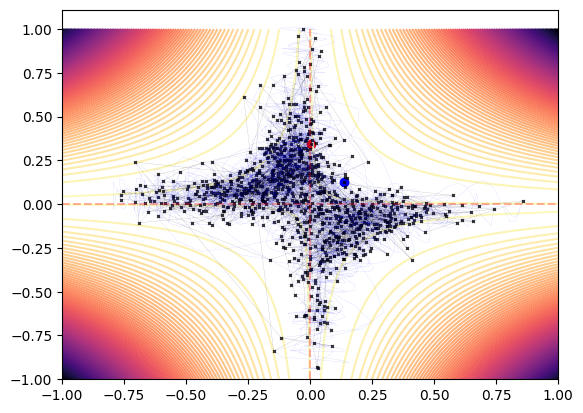

In [266]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random, vmap
import matplotlib.pyplot as plt

# Define the model 
@jit
def polynomial(w):
    w1, w2 = w
    # return (w1 - 1) * (w1**2 + w2**2)**4
    return w1 * w2
    # return (w1 - 1) * (w1**2 + w2**2)**3

@jit
def loglik(w, x, y, sigma):
    mu = polynomial(w) * x
    return jnp.sum(norm.logpdf(y, loc=mu, scale=sigma))

# Prior log-density
@jit
def log_prior(w, prior_sigma):
    return jnp.sum(norm.logpdf(w, loc=0, scale=prior_sigma))

# Full log-density
@jit
def log_density(w, x, y, sigma, prior_sigma, itemp=1.0):
    return loglik(w, x, y, sigma) * itemp + log_prior(w, prior_sigma)

# One step of Stochastic Gradient Hamiltonian Monte Carlo (SGHMC)
def sghmc_step(grad_log_density_fn, w, p, x_batch, y_batch, dt, key, C, data_size):
    dt = jnp.sqrt(dt)
    key, subkey = random.split(key)
    # Compute noisy stochastic gradient
    gradient = -grad_log_density_fn(w, x_batch, y_batch)
    noise = random.normal(key, shape=w.shape) * jnp.sqrt(2 * C * dt)
    p = p - (data_size / x_batch.shape[0]) * gradient * dt - C * p * dt + noise
    w = w + p * dt
    return w, p, key

# Simulate SGHMC
def simulate_sghmc(grad_log_density_fn, w_init, p_init, x, y, num_steps, leapfrog_steps, dt, key, C, batch_size):
    w = w_init
    p = p_init
    trajectory = [w]
    full_trajectory = [w]
    data_size = x.shape[0]
    for _ in range(num_steps):
        key, subkey = random.split(key)
        p = random.normal(subkey, shape=w.shape) * 0.8  # resample momentum
        # p = p_init
        for _ in range(leapfrog_steps):
            # Randomly select a minibatch
            idx = random.choice(key, jnp.arange(x.shape[0]), shape=(batch_size,), replace=False)
            x_batch = x[idx]
            y_batch = y[idx]
            w, p, key = sghmc_step(grad_log_density_fn, w, p, x_batch, y_batch, dt, key, C, data_size)
            full_trajectory.append(w)
        trajectory.append(w)
    return jnp.array(trajectory), jnp.array(full_trajectory)

# Simulate the system
# w_init = jnp.array([0.0, 0.0])
p_init = jnp.array([0.0, 0.0])
w_init = np.random.rand(2) * 0.5
# p_init = np.random.rand(2)
num_steps = 1000
leapfrog_steps = 10
dt = 0.0005
key = random.PRNGKey(2)
C = 0.1  # friction term
batch_size = 128
sigma = 0.5  # observation noise standard deviation
prior_sigma = 10.0  # prior standard deviation

# Generate the data
N = 1000
true_w = jnp.array([0., 0.])
key, subkey = random.split(key)
x = random.normal(key, shape=(N,)) * 2
y = polynomial(true_w) * x + sigma * random.normal(subkey, shape=(N,))


# Run SGHMC
itemp = 1 / jnp.log(N)
# itemp = 1.0
grad_log_density_fn = jit(grad(lambda w, x, y: log_density(w, x, y, sigma, prior_sigma, itemp=itemp), argnums=0))
trajectory, full_trajectory = simulate_sghmc(grad_log_density_fn, w_init, p_init, x, y, num_steps, leapfrog_steps, dt, key, C, batch_size)

# Plotting
print("Plotting")
val = np.max(np.abs(trajectory))
val = np.max([1.0, val])
w1_vals = jnp.linspace(-val, val, 100)
w2_vals = jnp.linspace(-val, val, 100)
# val = 0.01
# w1_vals = jnp.linspace(trajectory[:, 0].min() - val, trajectory[:, 0].max() + val, 100)
# w2_vals = jnp.linspace(trajectory[:, 1].min() - val, trajectory[:, 1].max() + val, 100)

W1, W2 = jnp.meshgrid(w1_vals, w2_vals)
Z = jnp.array([[log_density(jnp.array([w1, w2]), x, y, sigma, prior_sigma) 
                for w1 in w1_vals] 
                for w2 in w2_vals]) / N
plt.contour(W1, W2, Z, levels=100, cmap='magma')
plt.plot(trajectory[:, 0], trajectory[:, 1], 'kx--', linewidth=0.1, markersize=2, alpha=0.8)
plt.plot(full_trajectory[:, 0], full_trajectory[:, 1], 'b--', linewidth=0.1, markersize=0.1, alpha=0.5)
plt.scatter(trajectory[0, 0], trajectory[0, 1], c='red')
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], c='blue')
plt.vlines([0], ymin=-val, ymax=val, alpha=0.3, color="r", linestyles="dashed")
plt.hlines([0], xmin=-val, xmax=val, alpha=0.3, color="r", linestyles="dashed")
plt.show()


In [268]:
samples = trajectory
# samples = full_trajectory
# samples = trajectory[trajectory[:, 0] < 0.7]
hatlambda = (-np.mean([loglik(w, x, y, sigma) for w in samples]) + loglik(true_w, x, y, sigma)) / np.log(N)
hatlambda

Array(0.29958472, dtype=float32)

In [269]:
loglike_array = np.array([
    [loglik(w, x[i:i+1], y[i: i + 1], sigma) for w in samples]
    for i in range(x.shape[0])
])

KeyboardInterrupt: 